# Load Packages

In [59]:
#### Import required Packages ####
import numpy as np
import pandas as pd
import seaborn as sb
import datetime as dt
import matplotlib.pyplot as plt
from pandas.tseries.offsets import MonthEnd
import math
from scipy.stats import skew, kurtosis

# Seaborn
sb.set_style("ticks")
sb.mpl.rc("figure", figsize=(16,8))
sb.mpl.rc("font", size=14)
plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['ytick.direction'] = 'in'

# little function for later
def isNaN(string):
    return string != string

# Plotstyle

In [60]:
# Seaborn plot style ticks to have nicer looking plots
sb.set_style("ticks")
sb.mpl.rc("figure", figsize=(16,8))
sb.mpl.rc("font", size=14)
plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['ytick.direction'] = 'in'

# Load Data

In [61]:
# rawdata is direct import from excel

# Import of excel data, sheet by sheet
Data = pd.ExcelFile("Forward_data.xlsx")
# Fwd_Ask_raw = pd.DataFrame(pd.read_excel(Data, 0))
Fwd_Bid_raw = pd.DataFrame(pd.read_excel(Data, 4))
Spot_Ask_raw = pd.DataFrame(pd.read_excel(Data, 5))
Spot_Bid_raw = pd.DataFrame(pd.read_excel(Data, 6))

# keep a safe copy of the rawdata to compare the changes
# Fwd_Ask_points = Fwd_Ask_raw.copy()
Fwd_Bid_points = Fwd_Bid_raw.copy()
Spot_Ask = Spot_Ask_raw.copy()
Spot_Bid = Spot_Bid_raw.copy()

# Set date as index
# Fwd_Ask_points.set_index("Dates", inplace=True)
Fwd_Bid_points.set_index("Dates", inplace=True)
Spot_Ask.set_index("Dates", inplace=True)
Spot_Bid.set_index("Dates", inplace=True)

In [62]:
Fwd_Bid_points

,EURUSD1M Curncy,EURGBP1M Curncy,EURCHF1M Curncy,EURCNY1M Curncy,EURAUD1M Curncy,EURJPY1M Curncy,EURCAD1M Curncy,EURSGD1M Curncy,EURINR1M Curncy
Dates,,,,,,,,,
2000-01-03,23.75,13.40,-27.00,NaN,30.00,-29.20,21.00,-12.00,NaN
2000-02-01,NaN,13.70,-17.50,NaN,25.00,-28.90,19.90,1.00,NaN
2000-03-01,20.25,12.90,-19.30,NaN,26.00,-29.80,17.00,-14.00,NaN
2000-04-03,19.10,11.20,-13.90,NaN,25.75,-33.10,18.50,-21.00,NaN
2000-05-01,18.60,11.20,-13.40,NaN,28.00,-34.00,18.00,-19.00,NaN
...,...,...,...,...,...,...,...,...,...
2023-01-02,24.83,12.80,-13.08,-9.33,15.32,-27.19,29.50,25.25,35.67
2023-02-01,19.52,10.33,-12.64,-5.90,9.98,-28.31,23.33,16.53,28.68
2023-03-01,19.57,10.98,-15.57,-22.19,10.99,-36.32,22.52,14.42,31.69


In [63]:
# Divide Forward Points by 10000 to get them in decimals --> 1 forward point = 0.01% = 0.00001
# Fwd_Ask = Fwd_Ask_points / 1000
Fwd_Bid = Fwd_Bid_points / 1000
# Japan * 100
# Fwd_Ask.loc[:,"EURJPY1M Curncy"] = Fwd_Ask.loc[:,"EURJPY1M Curncy"] * 100
Fwd_Bid.loc[:,"EURJPY1M Curncy"] = Fwd_Bid.loc[:,"EURJPY1M Curncy"] * 100

In [64]:
Spot_Bid.columns = Fwd_Bid.columns
FX1M_Bid = Fwd_Bid.add(Spot_Bid, fill_value=0) # Forward Price is Spot Price + Future Points in decimals
#FX1M_Ask = Fwd_Ask.add(Spot_Ask, fill_value=0) # Forward Price is Spot Price + Future Points in decimals

In [65]:
# Forward Price Adjustments -> add TC for futures above Bid-Ask to resemble UBS rates and tenureTC
# Prep
sptTC_bps = 60 # Annualized extra transaction cost due to UBS broker
fwdTC_bps = 10 # Annualized extra transaction cost due to UBS broker
fwd_sign = 1 # 1 means going long the forward, -1 means going short the forward
spt_sign = -1 # 1 Glattstellen von Forward = taking opposite position
tenure_contracts = 1 # in months

Tenure_multiplier = tenure_contracts / 12 # approx to get fwdTC_bps and sptTC_bps relative to the duration (UBS calculates it like this)
SpotTC = sptTC_bps / 10000
ForwardTC = fwdTC_bps / 10000
# Adjusting FX1M & Spot
Spot = Spot_Ask * (1 + ((SpotTC * Tenure_multiplier) * spt_sign))
Forward = FX1M_Bid * (1 + (((ForwardTC * Tenure_multiplier) + (SpotTC * Tenure_multiplier)) * fwd_sign))


In [66]:
Forward.iloc[:-2,:]

,EURUSD1M Curncy,EURGBP1M Curncy,EURCHF1M Curncy,EURCNY1M Curncy,EURAUD1M Curncy,EURJPY1M Curncy,EURCAD1M Curncy,EURSGD1M Curncy,EURINR1M Curncy
Dates,,,,,,,,,
2000-01-03,1.048461,0.639473,1.578820,8.408902,1.585925,101.048911,1.503477,1.688484,44.021664
2000-02-01,0.971566,0.615159,1.592628,8.053595,1.561510,101.919418,1.427432,1.651863,42.259937
2000-03-01,0.993729,0.626665,1.588626,8.017574,1.632752,101.349086,1.428033,1.656065,42.298660
2000-04-03,0.974868,0.609455,1.566713,7.920618,1.595580,96.786426,1.403718,1.619944,41.585244
2000-05-01,0.934745,0.600630,1.552305,NaN,1.598812,96.266122,1.373080,1.548803,39.884452
...,...,...,...,...,...,...,...,...,...
2022-11-01,1.010079,0.872148,0.975689,7.222100,1.563912,144.590295,1.373181,1.426302,82.210958
2022-12-01,1.080580,0.871158,0.970546,7.425289,1.563461,140.091673,1.442261,1.460291,84.883266
2023-01-02,1.091766,0.897994,0.972187,7.343351,1.582493,136.410526,1.476661,1.455499,88.444132


In [67]:
Spot.iloc[1:-1,:]

,EURUSD Curncy,EURGBP Curncy,EURCHF Curncy,EURCNY Curncy,EURAUD Curncy,EURJPY Curncy,EURCAD Curncy,EURSGD Curncy,EURINR Curncy
Dates,,,,,,,,,
2000-01-31,0.970415,0.600899,1.608096,8.096550,1.522938,104.207870,1.405397,1.649875,42.803388
2000-02-29,0.963918,0.610794,1.605397,7.968314,1.560719,106.326810,1.397301,1.661169,42.483448
2000-03-31,0.955222,0.600500,1.591004,7.919538,1.573813,98.190880,1.384208,1.635582,41.718230
2000-04-28,0.911544,0.587736,1.564277,7.542527,1.561979,98.560695,1.348985,1.556721,39.771804
2000-05-31,0.937731,0.624688,1.575412,7.756220,1.635682,100.879535,1.403098,1.623988,41.797091
...,...,...,...,...,...,...,...,...,...
2022-11-30,1.040380,0.862828,0.984008,7.333032,1.532883,143.718105,1.395682,1.417891,84.331213
2022-12-30,1.070964,0.886596,0.991074,7.362017,1.574562,140.629650,1.453773,1.437581,88.134911
2023-01-31,1.086057,0.881579,0.995102,7.342927,1.539850,141.339295,1.445647,1.427486,88.704626


In [68]:
# Calculating Forward Hedge Returns
# BoM Long Forward Price / EoM Short SpotPrice
Hedge_return = np.divide(Forward.iloc[:-2,:] , Spot.iloc[1:-1,:]) -1


/var/folders/p7/g7d04mzx5wn88jp9x3dzpb9w0000gn/T/ipykernel_47406/1360141748.py:3: FutureWarning: Calling a ufunc on non-aligned DataFrames (or DataFrame/Series combination). Currently, the indices are ignored and the result takes the index/columns of the first DataFrame. In the future , the DataFrames/Series will be aligned before applying the ufunc.
Convert one of the arguments to a NumPy array (eg 'ufunc(df1, np.asarray(df2)') to keep the current behaviour, or align manually (eg 'df1, df2 = df1.align(df2)') before passing to the ufunc to obtain the future behaviour and silence this warning.
  Hedge_return = np.divide(Forward.iloc[:-2,:] , Spot.iloc[1:-1,:]) -1


In [69]:
Hedge_return.to_excel("Forward_long_hedge.xlsx", sheet_name='Fwd_Returns') 

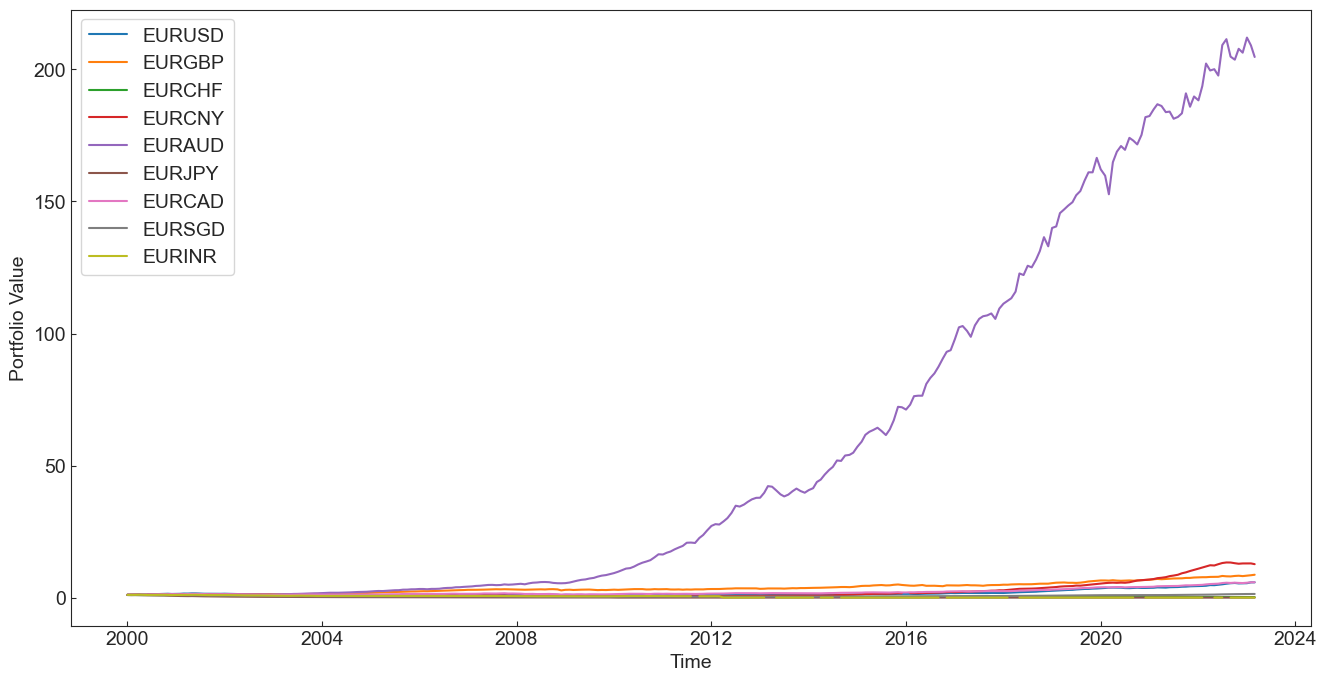

In [70]:
# Plot Strategy Performances
Hedge_returnNAV = np.cumprod(1 + Hedge_return)
# Create the line plot
plt.plot(Hedge_return.index, Hedge_returnNAV.iloc[:,0], label='EURUSD')
plt.plot(Hedge_return.index, Hedge_returnNAV.iloc[:,1], label='EURGBP')
plt.plot(Hedge_return.index, Hedge_returnNAV.iloc[:,2], label='EURCHF')
plt.plot(Hedge_return.index, Hedge_returnNAV.iloc[:,3], label='EURCNY')
plt.plot(Hedge_return.index, Hedge_returnNAV.iloc[:,4], label='EURAUD')
plt.plot(Hedge_return.index, Hedge_returnNAV.iloc[:,5], label='EURJPY')
plt.plot(Hedge_return.index, Hedge_returnNAV.iloc[:,6], label='EURCAD')
plt.plot(Hedge_return.index, Hedge_returnNAV.iloc[:,7], label='EURSGD')
plt.plot(Hedge_return.index, Hedge_returnNAV.iloc[:,8], label='EURINR')

# Set the x and y axis labels and legend
plt.xlabel('Time')
plt.ylabel('Portfolio Value')
plt.legend()

# Show the plot
plt.show()

In [71]:
# Lucas Function
def FXReturn(Spot_dta, Forward_dta, fwdTC_bps, sptTC_bps, tenureTC, fwd_sign, spt_sign):
    Tenure_multiplier = tenureTC / 12
    SpotTC = sptTC_bps / 10000
    ForwardTC = fwdTC_bps / 10000

    Spot = pd.DataFrame(Spot_dta)
    Spot_date = Spot.index
    Spot = Spot.apply(pd.to_numeric, errors='coerce').fillna(0)
    #Spot = Spot.iloc[:, :-3]

    Forward = pd.DataFrame(Forward_dta)
    Forward = Forward.apply(pd.to_numeric, errors='coerce').fillna(0)
    #Forward = Forward.iloc[:, :-3]

    Spot = Spot * (1 + ((SpotTC * Tenure_multiplier) * spt_sign))
    Forward = Forward * (1 + (((ForwardTC * Tenure_multiplier) + (SpotTC * Tenure_multiplier)) * fwd_sign))
    Return = Forward / Spot #Spot in t and Forward in t-30 or Spot EOM and Forward BOM

    Return = Return.replace([np.inf, -np.inf, np.nan], np.nan)
    Return[Return == 0] = np.nan
    Return = pd.DataFrame(Return - 1, index=Spot_date)

    return Return